# Coherent intermediate scattering functions

In [1]:
import h5py
import numpy as np
import numpy.random; numpy.random.seed(1)
import matplotlib.pyplot as plt
from pythonpackage.computation import correlation
from pythonpackage.plot import plot_fcoh
from notebookstyle import css_styling
%matplotlib inline
css_styling()

### Reading the trajectory file

In [2]:
file = 'Trajectories/spce300K_NVE_reduced.h5'

with h5py.File(file, 'r') as f:
    time = np.copy(f['time'])
    box_size = np.copy(f['box_size'])
    coordinates = np.copy(f['coordinates'])
    natoms = f['natoms'][0]

In [3]:
nmolecules = natoms // 3

In the following, we assume that the box is cubic and constant in time, and therefore characterized by a single parameter $L$. Here we check that this assumption is true for the data we have.

In [4]:
l = np.unique(box_size)
assert l.shape == (1,)
l = l[0]

### Computation of the weights

The order of the atoms is O, H1, H2 for each water molecule. The scattering lengths are $b_{coh}^{(O)} = 5.805 fm$ and $b_{coh}^{(H)} = -3.741 fm$. We compute the normalized weights $w_{coh}$ from these values.

In [5]:
b_O = 5.805
b_H = -3.741
w = np.array(nmolecules*[b_O, b_H, b_H])
w /= np.sqrt(np.sum(w**2))

### Averaging over $q$ vectors

We compute $F_{coh}(q, t)$ in an interval $[q_{min}, q_{max}]$, where $q_{min}$ is defined by the box size:

  $$ q_{min} = \frac{2\pi}{L} $$

The parameter $q_{max}$ can be freely chosen.

We generate all $q$ vectors whose $x$, $y$, and $z$ components are integer multiples of $q_{min}$. Since $F_{coh}(q, t) = F_{coh}(-q, t)$, we limit ourselves to $q_z \geq 0$.

Because the number of vectors increases rapidly with $q$, it is computationally too expensive to use all of them in the computation of $F_{coh}(q, t)$. Therefore we divide the spherical region in reciprocal space between $[q_{min}$ and $q_{max}$ into thinner shells and pick the desired number of vectors in each shell at random.

In [6]:
def q_shells(q_min, q_max, nshells):
    Δq = (q_max-q_min)/nshells
    shells = [[] for _ in range(nshells)]
    n_max = int(q_max/q_min)
    for nx in np.arange(-n_max, n_max+1):
        for ny in np.arange(-n_max, n_max+1):
            for nz in np.arange(0, n_max+1):
                if nx == 0 and ny == 0 and nz == 0:
                    continue
                qv = np.array([nx, ny, nz])*q_min
                qv_length = np.sqrt(np.dot(qv, qv))
                i = int((qv_length-q_min)/Δq)
                if i < nshells:
                    shells[i].append((qv, qv_length))
    ticks = q_min + Δq/2 + Δq * np.arange(nshells)
    return shells, ticks

In [7]:
def prune_randomly(shells, nmax):
    for i in range(len(shells)):
        if len(shells[i]) > nmax:
            numpy.random.shuffle(shells[i])
            shells[i] = shells[i][:nmax]

The range of $q$ we want to cover.

In [8]:
q_min = 2.*np.pi/l
q_max = 20.*q_min
print(q_min, q_max)

3.18764562643 63.7529125286


We divide this $q$ range into 30 spherical shells. If a shell contains more than 10 $q$ vectors, we use only 10 randomly chosen ones.

In [9]:
shells, ticks = q_shells(q_min, q_max, 30)
prune_randomly(shells, 10)

We compute $F_{coh}(q, t)$ for all $q$ vectors in a shell and take the average.
NOTE: the calculation may take a few minutes.

In [10]:
f_q = []

for i in range(len(shells)):
    f = 0.
    for qv, qv_length in shells[i]:

        rho = np.sum(w * np.exp(-1j*np.dot(coordinates, qv)), axis=1)
        f += correlation(rho)
    f_q.append(f.real / len(shells[i]))

f_q = np.array(f_q)

### Plotting $F(q, 0)$ - static structure factor

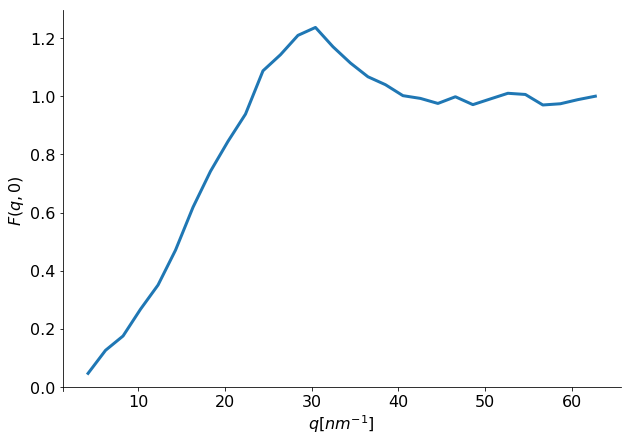

In [11]:
plot_fcoh(f_q[:, 0], ticks)

### Plotting $F(q, t)$ for selected values of $q$

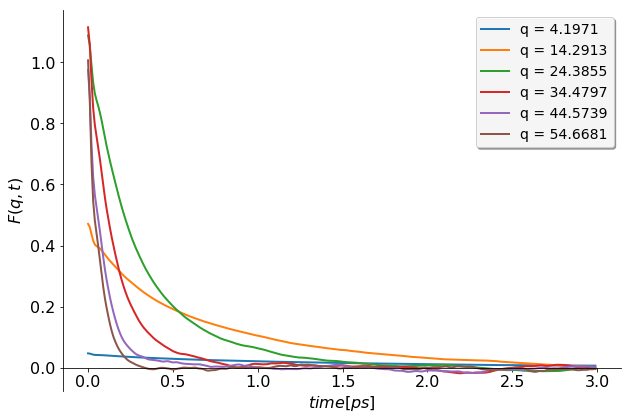

In [12]:
plot_fcoh(f_q, ticks, time, percentage=0.03, legend=True)